In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()
from pinecone import Pinecone
from langchain_huggingface import HuggingFaceEmbeddings

In [3]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")

pinecone_api_key = os.getenv("PINECONE_API_KEY")

In [4]:
pc = Pinecone(api_key=pinecone_api_key)
index_name = "10ms-db-bangla-book"

index = pc.Index(index_name)
index

In [5]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [6]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=embeddings)
vector_store

In [7]:
retriever = vector_store.as_retriever(
    search_type = "similarity",
    search_kwargs={
        "k": 3
    }
)

In [8]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model=os.getenv("LLAMA_MODEL")
)

## **Rag Prompt**

In [9]:
from langchain.prompts import PromptTemplate

rag_prompt = PromptTemplate(
    template=(
        "তুমি একজন সহায়ক বাংলা শিক্ষক। নিচের প্রশ্নটির উত্তর দিতে হবে শুধুমাত্র প্রদত্ত প্রাসঙ্গিক তথ্য ব্যবহার করে। "
        "যদি প্রশ্নের উত্তর নিচের প্রসঙ্গে না থাকে, তাহলে বিনয়ের সাথে বলবে যে উত্তর দেওয়ার মতো পর্যাপ্ত তথ্য নেই। "
        "অতিরিক্ত কিছু কল্পনা বা অনুমান করো না।\n\n"

        "প্রাসঙ্গিক প্রসঙ্গ:\n{context}\n\n"
        "প্রশ্ন:\n{question}\n\n"
        "উত্তর (বাংলায় সংক্ষিপ্ত এবং স্পষ্টভাবে দিন):"
    ),
    input_variables=["question", "context"],
)

In [10]:
def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    return context_text

In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

from IPython.display import display, Image
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    }
    | rag_prompt
    | llm
    | StrOutputParser()
)


# display(Image(rag_chain.get_graph().draw_mermaid_png()))

## **Defining The Graph Workflow**

In [12]:
from typing import TypedDict, Sequence, Annotated
from langchain_core.messages import BaseMessage
from pydantic import Field
import operator

class State(TypedDict):
    """This is is my graph state where store all conversations."""
    messages: Annotated[Sequence[BaseMessage], operator.add]


## **RAG Node**

In [22]:
def rag_node(state: State):
    print("--RAG Call--")
    
    question = state['messages'][0]
    print(question)
    
    
    
    rag_chain = (
        {
            "context": retriever | format_docs,
            "question": RunnablePassthrough()
        }
        | rag_prompt
        | llm
        | StrOutputParser()
    )
    response = rag_chain.invoke(question)
    print("rag-response", response)
    
    return {
        "messages": [response]
    }

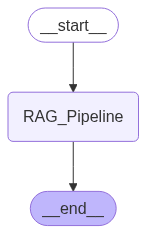

In [23]:
from langgraph.graph import START, StateGraph, END
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(State)

builder.add_node("RAG_Pipeline", rag_node)

builder.add_edge(START, "RAG_Pipeline")
builder.add_edge("RAG_Pipeline", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
config = {
    "configurable": {
        "thread_id": "chat_1"
    }
}

In [25]:
response = graph.invoke(
    {
        "messages": ["অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?"]
    },
    config=config
)

--RAG Call--
অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?
rag-response উদ্দীপকের তথ্য অনুসারে অনুপমের ভাষায় সুপুরুষ বলা হয়েছে মামাকে।


In [27]:
response["messages"][-1]

'উদ্দীপকের তথ্য অনুসারে অনুপমের ভাষায় সুপুরুষ বলা হয়েছে মামাকে।'

In [29]:
graph.get_state(config=config).values

{'messages': ['অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?',
  'উদ্দীপকের তথ্য অনুসারে অনুপমের ভাষায় সুপুরুষ বলা হয়েছে মামাকে।']}